## Алгоритм градиентного бустинга (GBM)

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

график зависимости ошибки на обучающей и тестовой выборках от числа максимальной глубины дерева

---

In [11]:
train_errors = []
test_errors = []
n_trees = 10 # Число деревьев в ансамбле
# max_depth = 3 # Максимальная глубина деревьев
coefs = [1] * n_trees
eta = .05
plot_range=25
for n in range(1, plot_range):
    trees = gb_fit(n_trees, n, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_errors.append(mean_squared_error(y_train, train_prediction))
    train_errors.append(mean_squared_error(y_test, test_prediction))

In [12]:
import matplotlib.pyplot as plt

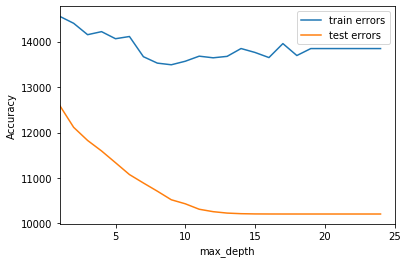

In [13]:
x = list(range(1, plot_range))
plt.xlim(1, plot_range)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

## график зависимости ошибки на обучающей и тестовой выборках от числа деревьев в ансамбле

---

In [14]:
train_errors = []
test_errors = []
# n_trees = 10 # Число деревьев в ансамбле
max_depth = 3
eta = .05
plot_range=50
for n in range(1, plot_range):
    coefs = [1] * n
    trees = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_errors.append(mean_squared_error(y_train, train_prediction))
    train_errors.append(mean_squared_error(y_test, test_prediction))

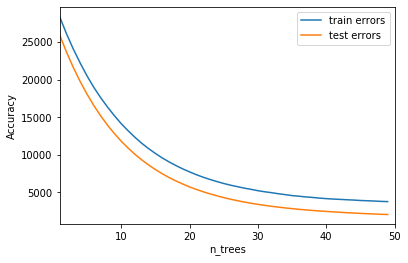

In [15]:
x = list(range(1, plot_range))
plt.xlim(1, plot_range)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('n_trees')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

## Выводы о зависимости ошибки от количества деревьев в ансамбле и максимальной глубины дерева:
1 Максимальная глубина дерева – зависит от характера данных. В нашем случае все что выше трех - зашумляет и делает менее эффективной модель. Возможно очистка данных, введение новых фактовров или комбинирование существующих позволят извлечь пользу из большей глубины, но в существующей модели идти дальше 3х нет смысла.

2) Количество деревьев напрямую влияет на качество предсказаний – чем их больше, тем модель точнее, однако это усложняет и делает более долгой работу модели, и прирост показателя от каждого нового дерева все меньше. Таким образом этот параметр следует оптимизировать исходя из имеющегося времени и процессорных мощностей с одной стороны и с учетом необходимой (или достаточной) точности модели с другой.
